# Image Classification Challenge: Dogs vs Cats

**Note**: You're currently using Google Colaboratory, a cloud-based version of Jupyter Notebook. This document contains both text cells for documentation and code cells that can be executed. If you're new to Jupyter Notebook, consider watching this [3-minute introduction video](https://www.youtube.com/watch?v=inN8seMm7UI) before starting this challenge.

---

## Overview

In this challenge, you'll develop a convolutional neural network (CNN) to classify images of dogs and cats. Utilizing TensorFlow 2.0 and Keras, your goal is to achieve at least 63% accuracy in distinguishing between the two. Achieving 70% or higher will earn you extra credit!

The challenge involves partially provided code; you'll need to complete certain sections to progress. Follow the instructions in each text cell carefully to understand what's required in the corresponding code cell.

## Dataset Structure

Upon downloading the data, you'll find it organized as follows, with the `test` directory containing unlabeled images:



```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```


## Instructions

1. **Import Libraries**: The first code cell will include necessary library imports.
2. **Download Data & Set Variables**: The second cell is for data download and setting key variables.
3. **Your Code**: Starting from the third cell, you'll be writing your own code to implement the CNN.

Feel free to adjust the epochs and batch size to fine-tune your model, though it's not a requirement for completing the challenge.


In [1]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
seed_value= 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [3]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = './cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Image Data Preparation

**Now it's your turn!** Your task is to correctly set up the variables below. Initially set to `None`, these variables should be assigned appropriate values as per the instructions.

## Task

You will create image generators for the training, validation, and test datasets using the `ImageDataGenerator` class. This tool will read and decode the images, converting them into floating-point tensors. Specifically, you'll use the `rescale` argument to adjust the pixel values from a range of 0-255 to a normalized range of 0-1. This normalization helps in improving the performance of the model by scaling the inputs.

### Instructions

1. **Initialize Image Generators**: For each of the datasets (train, validation, test), create an instance of `ImageDataGenerator` with the `rescale` parameter set to rescale the image tensors.

2. **Generate Data**: Utilize the `flow_from_directory` method of your image generators to set up the `*_data_gen` variables. Provide the necessary arguments including:
    - `batch_size`: The number of images to process in a single batch.
    - `directory`: The path to the target directory (for each dataset).
    - `target_size`: The dimensions to which all images found will be resized (`(IMG_HEIGHT, IMG_WIDTH)`).
    - `class_mode`: Defines the type of label arrays that are returned: `"binary"` for 1D binary labels, `"categorical"` for 2D one-hot encoded labels, etc.
    - For `test_data_gen`, ensure you set `shuffle=False` in the `flow_from_directory` call. This is crucial for maintaining the order of the test images, aligning with the expected order of predictions.

### Note on Test Data
- The `test_data_gen` requires careful attention due to its unique directory structure and the necessity to keep the image order fixed (hence `shuffle=False`). Observing the directory structure will aid in correctly setting up this generator.

### Expected Output

After executing your code, the output should confirm the successful preparation of your image datasets, resembling the following:



```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```


This output indicates that your image data generators are correctly set up and ready for use in training and evaluating your model.


In [4]:
# 3
rescale=1/255

train_image_generator = ImageDataGenerator(rescale=rescale)
validation_image_generator = ImageDataGenerator(rescale=rescale)
test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')


test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    classes=["."], # this is the trick bit
    directory='./cats_and_dogs',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 3050 images belonging to 1 classes.


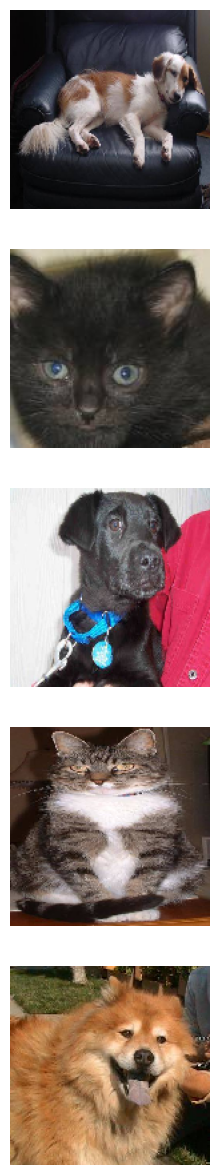

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


# Augmenting Training Data

Due to the limited number of training examples, there's a significant risk of overfitting. A common strategy to mitigate this issue is to augment the training data by applying random transformations to the existing images. This approach generates more diverse training examples, helping the model generalize better to unseen data.

## Task

Recreate your `train_image_generator` using the `ImageDataGenerator` class from TensorFlow's Keras API, incorporating several random transformations to augment your data.

### Instructions

1. **Initialize `ImageDataGenerator`**: Create a new instance of `ImageDataGenerator` for the training dataset. Ensure you include the `rescale` argument to normalize the image pixels values between 0 and 1.

2. **Apply Random Transformations**: Enhance the data generator by adding 4-6 random transformations as arguments. Some common transformations include:
    - `rotation_range`: A degree range within which to randomly rotate pictures.
    - `width_shift_range` and `height_shift_range`: Ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
    - `shear_range`: For randomly applying shearing transformations.
    - `zoom_range`: For randomly zooming inside pictures.
    - `horizontal_flip`: For randomly flipping half of the images horizontally — relevant when there are no assumptions of horizontal asymmetry (e.g., real-world pictures).
    - `fill_mode`: The strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

### Example

train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2)


In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=rescale,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest"
)

# Visualizing Data Augmentation

In this section, we'll visualize the impact of our data augmentation strategy on the training images. This step is crucial for understanding how the random transformations applied by `ImageDataGenerator` can lead to diverse training examples, thereby helping to prevent overfitting.

## What's Happening?

- **Data Generation**: The `train_data_gen` is set up using the newly configured `train_image_generator` with data augmentation. This process mirrors the previous setup but incorporates the random transformations we've added.
- **Image Visualization**: We will then display a single image from our dataset five times, each time applying a different set of transformations. This illustrates the variety of training examples that our model will see, without needing to manually expand the dataset.

## No Action Required

For this specific cell, **no action is required on your part**. Simply run the cell to execute the predefined operations:
- The creation of `train_data_gen` using the augmented `train_image_generator`.
- The visualization of augmented images.

This automatic process showcases the power of data augmentation in generating diverse training samples from a single image, effectively demonstrating how such transformations can enhance the model's ability to generalize from limited data.


Found 2000 images belonging to 2 classes.


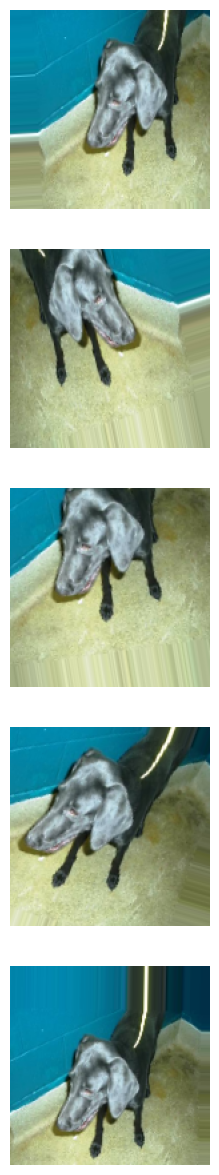

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# Ensure TensorFlow is using GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.13.0
Num GPUs Available:  1


# Building and Compiling the CNN Model

In this section, you will define and compile the convolutional neural network (CNN) model that predicts class probabilities. The model will be built using TensorFlow's Keras API, specifically employing the Sequential model framework to facilitate a linear stack of layers.

## Model Architecture

1. **Convolutional Layers**: Begin with a stack of `Conv2D` layers. These layers will help the model to learn the patterns in the images.
2. **Pooling Layers**: Follow each `Conv2D` layer with a `MaxPooling2D` layer. Pooling reduces the dimensionality of the data by downscaling, making the detection of features invariant to scale and orientation changes.
3. **Fully Connected Layer**: After the convolutional and pooling layers, flatten the network and add a fully connected (`Dense`) layer. This layer is activated by a ReLU activation function, serving as a classifier on top of the features extracted by the convolutions.

## Compiling the Model

- **Optimizer**: Choose an optimizer that will update the model's weights based on the observed data and the loss function. Common choices include `adam`, `sgd`, etc.
- **Loss Function**: Use a loss function suitable for a classification problem. For binary classification, `binary_crossentropy` is a common choice. For multi-class classification, consider `categorical_crossentropy`.
- **Metrics**: Include `accuracy` in the metrics to track the training and validation accuracy of each epoch. This provides insight into the performance of your model throughout the training process.

### Example Code

```python
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


In [9]:
# 7
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

2024-03-12 08:48:05.120395: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-12 08:48:05.120424: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-12 08:48:05.120433: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-12 08:48:05.120743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-12 08:48:05.120771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Training the Model

With your convolutional neural network (CNN) model built and compiled, the next step is to train it using the dataset you've prepared. Training is accomplished by calling the `fit` method on your model, which adjusts the model parameters (weights) to minimize the loss and improve accuracy.

## Steps for Training

1. **Prepare Data**: Ensure your training (`train_data_gen`) and validation (`val_data_gen`) datasets are ready for use.
2. **Call `fit` Method**: Use the `fit` method on your model to start the training process. You'll need to provide it with the training data, validation data, and specify how many epochs to train for.

### Parameters to Specify

- **`x`**: Typically, you'll pass your training data generator as this argument.
- **`steps_per_epoch`**: This controls how many batches of samples to use for one epoch. Setting this to the total number of samples divided by the batch size is a common practice.
- **`epochs`**: The number of times the learning algorithm will work through the entire training dataset. Choose a number that balances between underfitting and overfitting.
- **`validation_data`**: Your validation data generator. It's used to evaluate the loss and any model metrics at the end of each epoch.
- **`validation_steps`**: Similar to `steps_per_epoch`, but for validation data. Set this to the total number of validation samples divided by the validation batch size.

### Example Code

```python
history = model.fit(
        x=train_data_gen,
        steps_per_epoch=10,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size)


In [10]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    steps_per_epoch=10,
)


Epoch 1/30


2024-03-12 08:48:05.959216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.9286 - accuracy: 0.4878

2024-03-12 08:48:10.698295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 7s 617ms/step - loss: 0.9286 - accuracy: 0.4878 - val_loss: 0.7163 - val_accuracy: 0.5000
Epoch 2/30
10/10 [==============================] - 6s 584ms/step - loss: 0.7007 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
10/10 [==============================] - 6s 569ms/step - loss: 0.6906 - accuracy: 0.5365 - val_loss: 0.6972 - val_accuracy: 0.4590
Epoch 4/30
10/10 [==============================] - 5s 551ms/step - loss: 0.6946 - accuracy: 0.5114 - val_loss: 0.6952 - val_accuracy: 0.5020
Epoch 5/30
10/10 [==============================] - 6s 560ms/step - loss: 0.6890 - accuracy: 0.5242 - val_loss: 0.6816 - val_accuracy: 0.5270
Epoch 6/30
10/10 [==============================] - 5s 550ms/step - loss: 0.6793 - accuracy: 0.5547 - val_loss: 0.6566 - val_accuracy: 0.6110
Epoch 7/30
10/10 [==============================] - 5s 544ms/step - loss: 0.6606 - accuracy: 0.6047 - val_loss: 0.6512 - val_accuracy: 0.5880
Epoch 8/30
10/10 

# Visualizing Model Performance

After training your model, it's essential to evaluate its performance by examining the accuracy and loss metrics. These metrics provide insight into how well your model is learning from the training data and generalizing to the validation data.

## What to Expect

By running the next cell, you will generate plots that depict the model's training and validation accuracy, as well as its training and validation loss over each epoch. These visualizations are crucial for identifying trends such as:
- **Overfitting**: If the training accuracy significantly exceeds the validation accuracy.
- **Underfitting**: If both training and validation accuracies are low or if the model performs poorly on both the training and validation sets.

## Steps

1. **Execute the Cell**: Simply run the next code cell to generate the visualizations. No modifications are needed.
2. **Interpret the Plots**: Look for the following indicators:
   - A closing gap between training and validation accuracy suggests good generalization.
   - A decreasing trend in loss over epochs indicates learning progress.

## Understanding the Outputs

- **Accuracy Plot**: Shows the comparison between the training accuracy and validation accuracy across epochs.
- **Loss Plot**: Illustrates how the training loss and validation loss change throughout the training process.

These plots are invaluable tools for tuning your model further. They can help you decide if you need to adjust the model architecture, data augmentation strategies, or training parameters (like the learning rate).

Now, go ahead and run the next cell to visualize your model's learning journey!


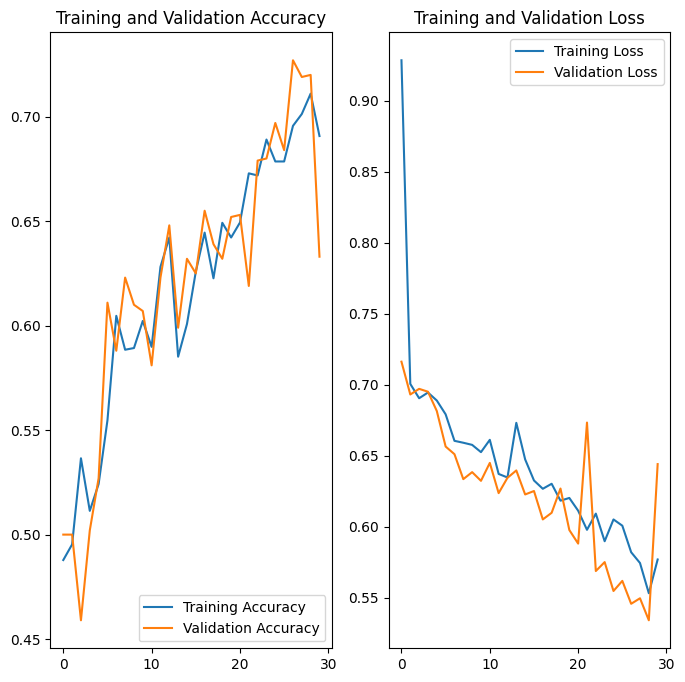

In [11]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Making Predictions with Your Model

Having trained your model, the next exciting step is to use it for predicting whether new, unseen images are of cats or dogs. This is a crucial test of your model's ability to generalize from the training data to real-world examples.

## Task

You will now use the `test_data_gen` dataset to predict the class (cat or dog) of each image. Your task involves generating predictions and then visualizing these images along with their predicted classes.

### Instructions

1. **Generate Predictions**: Use your trained model to predict the class of each image in the `test_data_gen`. The output should be a list of probabilities that indicate the likelihood of each image being a dog (or conversely, a cat).
2. **Convert Probabilities to Integers**: Depending on your model's final layer activation (e.g., softmax for multi-class classification), you may need to convert the output probabilities to a binary form (0 or 1) representing cats or dogs.
3. **Visualize Predictions**: Utilize the `plotImages` function provided in your environment. Pass in the test images along with their corresponding probabilities or class predictions.

### Expected Outcome

Upon running your final cell, you should see all 50 test images displayed with labels indicating the model's confidence level (as a percentage) that each image is a cat or a dog. This visualization not only showcases your model's predictive power but also aligns with the accuracy metrics observed in the previous steps.

### Note on Model Accuracy

- The accuracy of your predictions will reflect the performance metrics observed during training and validation. Enhancing the training dataset size or diversity could potentially increase model accuracy.

### Example Code Snippet

```python
# Assuming 'model' is your trained model and 'test_data_gen' is your test data generator
probabilities = model.predict(test_data_gen)
# Convert probabilities to binary predictions, 1 for dog and 0 for cat, based on a threshold (e.g., 0.5)
predictions = [1 if prob > 0.5 else 0 for prob in probabilities]

# Now call the plotting function with test images and their predicted labels
plotImages(test_images, predictions)


In [12]:
predictions = model.predict(test_data_gen)
probabilities = [1 if a[0]<a[1] else 0 for a in predictions]

 1/24 [>.............................] - ETA: 5s

2024-03-12 08:50:54.109353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 4s 145ms/step


In [13]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 54.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
